# Notebook to run simulations for average of shortest path among (partially) random points within circle
- Circle represents a city
- points represent stops within that city which a bus has to stop at

In [6]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [1041]:
_a = 0.2
_b = 0.3
_gamma = (0/8-0/16)*.5*2*math.pi


(_a**2+_b**2-2*_a*_b*math.cos(_gamma))**.5

0.10000000000000005

In [1255]:
n_rings=30
n_opts=8

[n_opts*math.log(i+1)/math.log(n_rings) for i in range(n_rings)]

[0.0,
 1.6303603767240493,
 2.584060059769236,
 3.2607207534480986,
 3.7855795635067144,
 4.214420436493285,
 4.57700022832395,
 4.891081130172148,
 5.168120119538472,
 5.415939940230764,
 5.640120237012592,
 5.8447808132173344,
 6.033050292913146,
 6.207360605047999,
 6.36963962327595,
 6.521441506896197,
 6.664037457706457,
 6.7984804962625205,
 6.9256527011143385,
 7.046300316954813,
 7.161060288093186,
 7.270480613736642,
 7.375036174811689,
 7.475141189941384,
 7.571159127013429,
 7.663410669637196,
 7.752180179307707,
 7.837720981772049,
 7.9202597253344615,
 8.0]

In [1262]:
def flex_rings(
    n_rings:int=5, 
    n_on_outer_ring:int=2**6, 
    min_n_on_ring:int=2, 
    max_dist:int=2*math.pi/128, 
    spread_ngls:bool=True, 
    s=True,
    min_pnt_dist = 0.01, # [0,1) # minimum distance of a point to any other point
    max_pnt_dist = 2, # (0,1] # maximum distance for any point to closest other point
    #max_pnt_dist = 2, # (0,1] # maximum distance of any position on ring to closest point
    #max_pnt_dist = 2, # (0,1] # maximum distance of any position within circle to closest point unit circle to closest point for all possible locs in circle
    max_dens=None,
    ) ->list:
    """
    return the number of points that are on each ring
    - point density can be a bit higher towards middle
    
    """
    
    # by def: len(n_opts) <= n_rings, min(n_opts)>= min_n_on_ring, max(n_opts) == n_on_outer_ring
    n_opts = [n for n in [int(n_on_outer_ring*2**(i-n_rings+1)) for i in range(0, n_rings)] if not n < min_n_on_ring]
    # consider density within current ring +/- *.5
    # density with previous ring +.5 - 1.5
    # go from inside to outside? or from outside to inside?
    ring_dicts = [{'r':0,'n':1,'o':0}] # list of radius and n_points # maybe add already add bool for offset?
    # for i, (r0, r1, r2) in enumerate(zip(ring_rads[:-2], ring_rads[1:-1], ring_rads[2:])):

    for i in range(0,n_rings):
        # ring inside of current one
        dct_in1 = ring_dicts[-1]
        r_in1, n_in1, o_in1 = dct_in1['r'], dct_in1['n'], dct_in1['o']
        # set number of pts on ring
        n = max(n_in1, n_opts[math.floor(i-(n_rings-len(n_opts))*i/n_rings)])
        n = max(n_in1, n_opts[min(len(n_opts)-1,int(len(n_opts)*math.log(i+1)/math.log(n_rings)))])
        
        while True:
            # define whether angles should be offsetted
            o = int(spread_ngls and not o_in1 and (s or n_in1 ==  n))
            # print('o',o, 'o_in1',o_in1)
            # points within circle including current ring
            n_within = sum([d['n'] for d in ring_dicts]) + n

            ########### set minimum for radius ###########
            # smalles possible radius (used for i == 0 unless points would be to close on the same ring)
            r_min_dist_to_center = min_pnt_dist
            
            # optain minimum radius that does holds density constant, radius will be scaled at the end
            # max_dens >= n_within/(2*math.pi*r**2)
            # r >= ( n_within/(2*math.pi*max_dens) )**5=
            # r_opt = n_within**.5
            # maybe also needs to check of density within last is to high
            
            # set minimum radius, s.t.
            r_min_dist_pts_same_ring = .5*((2* min_pnt_dist + (math.cos((2* math.pi)/n))**2)**.5 + math.cos((2* math.pi)/n))
            
            # calc distance to closest point on same ring
            # min_pnt_dist <= (2*r1**2-2*r1**2*math.cos(_gamma))**.5 # solve for r1
            gamma_wthn = 2* math.pi / n
            r_min_dist_pts_same_ring = min_pnt_dist/(2-2*math.cos(gamma_wthn))**.5

            # calc distance to closest point from inner layer
            gamma_btwn = abs(o_in1/n_in1-o/n)*.5*2*math.pi
            # min_pnt_dist <= (r0**2+r1**2-2*r0*r1*math.cos(gamma_btwn))**.5 # solve for r1
            # 0 <= r1**2  -  r1 * 2*r0*math.cos(gamma_btwn)  +  r0**2 - min_pnt_dist**2
            # r1/2 = r0*(math.cos(gamma_btwn) +/- ( (math.cos(gamma_btwn))**2 + (min_pnt_dist/r0)**2 - 1 )**.5)
            r_min_dist_to_inner_ring = 0 if i==0 else 0 if ((math.cos(gamma_btwn))**2 + (min_pnt_dist/r_in1)**2 - 1)< 0  else (
                r_in1*(math.cos(gamma_btwn) + ((math.cos(gamma_btwn))**2 + (min_pnt_dist/r_in1)**2 - 1)**.5) )
            
            r_min_dist_to_inner_with_same_offset = next((dct['r']+min_pnt_dist for dct in ring_dicts[::-1] if dct['o'] == o), 0)
            
            # make sure density is not too high
            r_const_density = 0 if i == 0 else (n_within / (2*math.pi*max_dens))**.5
            # print(
            #     'n',n,'nw',n_within,'nd', (n_within / (2*math.pi*r_const_density**2)) if i>0 else "--",
            #     'r_sam',r_min_dist_pts_same_ring,
            #     'r_den', r_const_density, 
            #     'r_cen', r_min_dist_to_center,
            #     'r_in', r_min_dist_to_inner_ring,
            #     'r_io', r_min_dist_to_inner_with_same_offset,
            #     )
            # print(['r_sam', 'r_den', 'r_cen','r_in','r_io'][
            #         [r_min_dist_pts_same_ring, r_const_density, r_min_dist_to_center, r_min_dist_to_inner_ring, r_min_dist_to_inner_with_same_offset].index(
            #             max([r_min_dist_pts_same_ring, r_const_density, r_min_dist_to_center, r_min_dist_to_inner_ring, r_min_dist_to_inner_with_same_offset])
            #             )],)

            r = max(
                r_min_dist_to_center, 
                r_min_dist_to_inner_ring,
                r_min_dist_to_inner_with_same_offset,
                r_min_dist_pts_same_ring,
                r_const_density,
                )
            
            max_dist_within_ring = (2*r**(1-math.cos(gamma_wthn/2)))**.5
            max_dist_to_inner_ring = (r_in1**2+r**2-2*r_in1*r*math.cos(_gamma))**.5
            if max_pnt_dist<min(max_dist_within_ring, max_dist_to_inner_ring) or n == n_on_outer_ring or n > n_in1:
                break
            # print(i, max_dist_to_inner_ring, max_dist_to_inner_ring)
            n = n_opts[n_opts.index(n)+1]

            # print('new_den',(n_within / (2*math.pi*r**2)))
            ########### set upper bounds for radius ###########
            # check whether max distance is violated:
                # check disance to points with at ring inside
                # maybe check distance that enough points are on ring?
                # how about first distributing rings and then from inside to outside put as many points as possible?

            
        if i == 0 and max_dens==None: 
            max_dens = n_within / (2*math.pi*r**2)
            # print("max_pnt_dist",r,max_pnt_dist,max_pnt_dist*(r))
            max_pnt_dist = max_pnt_dist* r**1
        ring_dicts.append( {'r':r, 'n':n, 'o':o} )
 
    # print(max_dens, 'rnorm', [dct['r'] for dct in ring_dicts])
    # normalize such that outer radius equals 1
    ring_dicts = [{**d, 'r':d['r']/ring_dicts[-1]['r']} for d in ring_dicts]
    
    return ring_dicts
f_r = flex_rings(n_rings=8, n_on_outer_ring=2**2, min_n_on_ring=2, spread_ngls=True)
# f_r

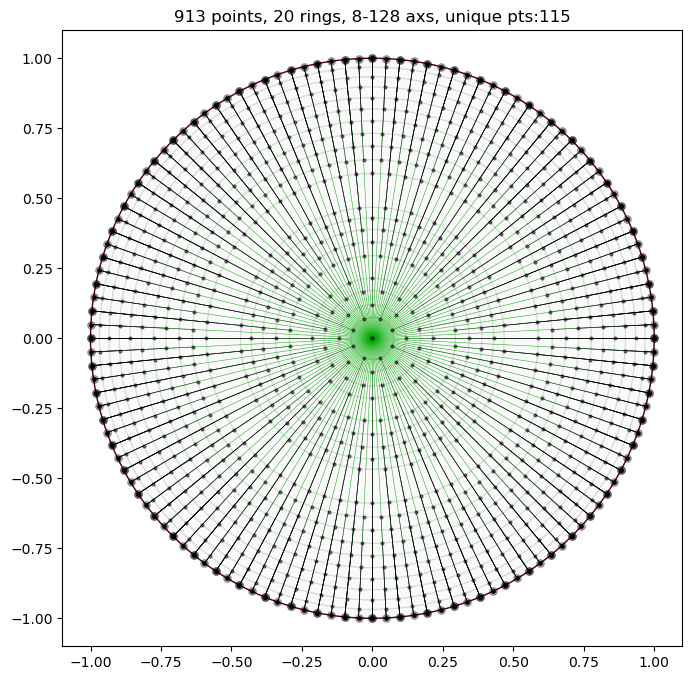

In [1263]:
pts_in_shp = c_pts_on_crcl_rings(n_rings=20, n_on_outer_ring=64, min_n_on_ring=8, s=True, min_pnt_dist=0.00001, max_pnt_dist=0.0000001)

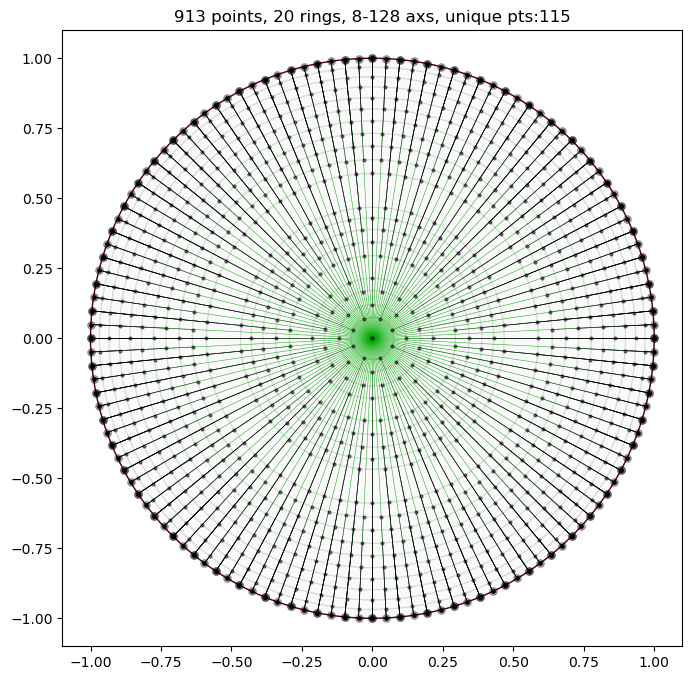

In [1264]:
pts_in_shp = c_pts_on_crcl_rings(n_rings=20, n_on_outer_ring=64, min_n_on_ring=8, s=True, min_pnt_dist=0.1, max_pnt_dist=0.0000001)

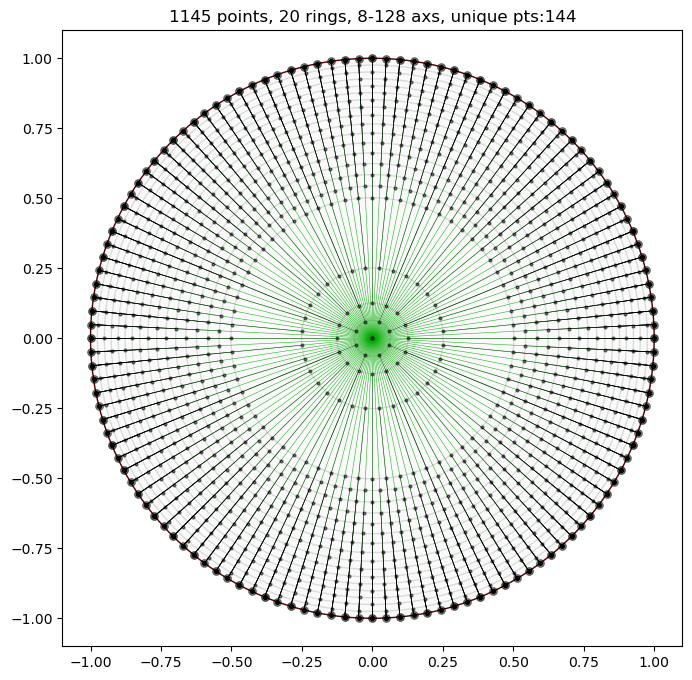

In [1265]:
pts_in_shp = c_pts_on_crcl_rings(n_rings=20, n_on_outer_ring=64, min_n_on_ring=8, s=True, min_pnt_dist=0.001, max_pnt_dist=1.0000001)

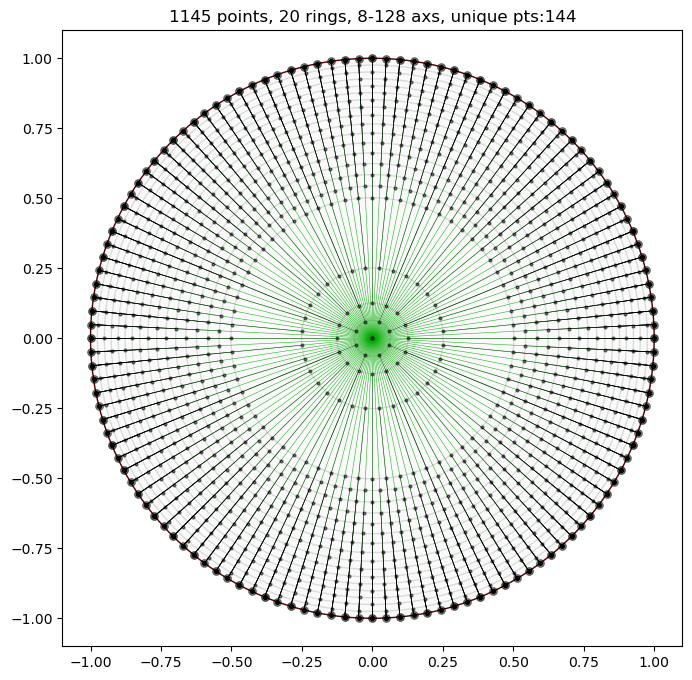

In [1266]:
pts_in_shp = c_pts_on_crcl_rings(n_rings=20, n_on_outer_ring=64, min_n_on_ring=8, s=True, min_pnt_dist=0.001, max_pnt_dist=110.0000001)

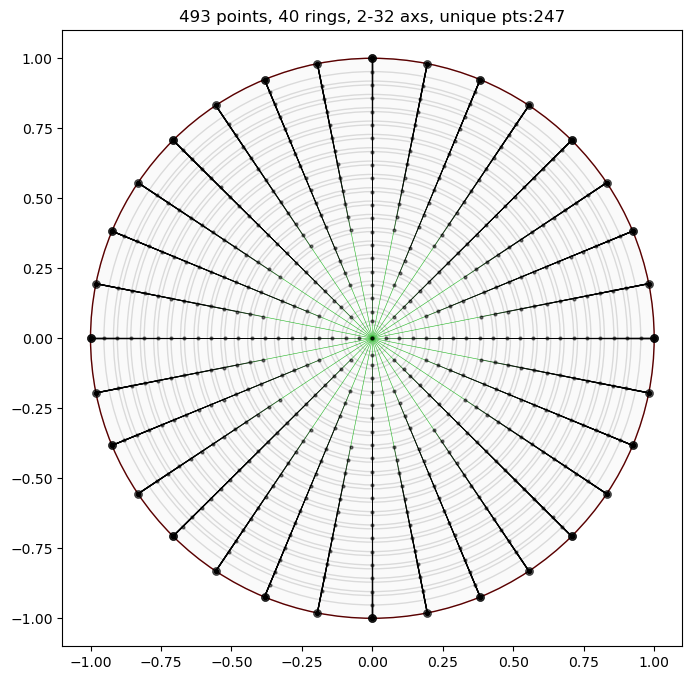

In [1267]:
pts_in_shp = c_pts_on_crcl_rings(n_rings=40, n_on_outer_ring=4**2, s=False, min_pnt_dist=0.001, max_pnt_dist=0.1, min_n_on_ring=2)

In [1240]:
def c_pts_on_crcl_rings(
    n_pts:int=10,
    shape_scale:int = 1, 
    loc_descr_str:str='rings',#'grid', 'rings'
    min_dist:int=0,# minimum distance between pts
    n_rings:int=20,#specify how many radiuses should  pts density 
    d_rings_scale=lambda r_i: r_i**.75,# r_i: r_i=even distance between rings => higher density close to center 
    n_pts_f_str:str='const_den_sym',# 'const_n', 'const_den', 'const_den_sym', 
    n_pts_ring_f=lambda r_i:24,#max(1,int(4*r_i))#r_i:1 = same amount of pointd on each ring, r_i:r_i = same point density on each ring 
    n_on_outer_ring=2**6,
    min_n_on_ring=2,
    spread_ngls:bool=True, # make sense to create more even distribution 
    regular:bool=True, # specifies whether pts distrubted evenly or not if loc_descr_str in 'grid', 'rings' 
    distr_centrality:int=1,# same as d_rings_scale and n_pts_ring_f?
    plot:bool=True,#,
    s=True,
    min_pnt_dist = 0.005, # [0,1) # minimum distance of a point to any other point
    max_pnt_dist = 2 ,# (0,1] # minimum distance of a point to closest point
    max_dens=10,
)->list:

    fig, ax = plt.subplots(figsize=(8,8))
    ax.add_patch( plt.Circle((0., 0.), 1, facecolor='#00000005', edgecolor='#600') )
    ring_dicts = flex_rings(
        n_rings=n_rings, n_on_outer_ring=n_on_outer_ring, min_n_on_ring=min_n_on_ring, spread_ngls=spread_ngls, 
        s=s, min_pnt_dist=min_pnt_dist, max_pnt_dist=max_pnt_dist,
        )# pass arg spread_ngls
    
    # add angles for for points on each rings. Consider offset
    ring_dicts = [{**dct, 
        'ngls': [ ngl for ngl in np.linspace(.5*dct['o']/dct['n']*2*math.pi, (dct['n']-1+.5*dct['o'])/dct['n']*2*math.pi, dct['n']) ]
    } for dct in ring_dicts]

    ring_dicts = [{**dct, 
        'pts': [ (math.cos(ngl), math.sin(ngl) ) for ngl in dct['ngls'] ]
    } for dct in ring_dicts]

    # (str(ring_dicts[0]['n'])) 
    # if n_rings < 2 else  
    # (str(ring_dicts[0]['n']+ring_dicts[1]['o']*ring_dicts[1]['n']) + '-' + str(ring_dicts[-1]['n']+ring_dicts[-2]['o']*ring_dicts[-2]['n']))
    if plot:
        for ngl in ([] 
        if n_rings < 2 and ring_dicts[-1]['n']==ring_dicts[-2]['n'] and ring_dicts[-1]['o'] != ring_dicts[-2]['o'] else 
        ring_dicts[-2]['ngls']) + ring_dicts[-1]['ngls']:
            plt.plot(
                np.array([0, 1])*math.cos(ngl), 
                np.array([0, 1])*math.sin(ngl), 
                color='#00aa00dd', linewidth=.4)
        for i,dct in enumerate(ring_dicts):
            ax.add_patch( plt.Circle((0., 0.), dct['r'], facecolor='#00000000', edgecolor='#00000020') )
            for ngl in dct['ngls']:
                plt.plot(
                    np.array([dct['r'], int(dct['r']>0)])*math.cos(ngl), 
                    np.array([dct['r'], int(dct['r']>0)])*math.sin(ngl), 
                    color='#00000080', linewidth=.4+10*i/len(ring_dicts)/n_on_outer_ring, 
                    marker='o', markersize=2)
    # flat list of all pts
    all_pts = np.array([item for sublist in [dct['pts'] for dct in ring_dicts] for item in sublist])

    ax.scatter(all_pts[:,0],all_pts[:,1], alpha=.1, color='#00000000', linewidths=0.05, edgecolor='#000')
    ax.set_xlim(-1.1,1.1)
    ax.set_ylim(-1.1,1.1)
    ax.set_title(
        str(len(all_pts))+' points, ' +
        str(n_rings) + ' rings, ' +
        (
            (str(ring_dicts[1]['n'])) 
            if n_rings < 2 else  
            (str(ring_dicts[1]['n']) + '-' + str(ring_dicts[-1]['n']+ring_dicts[-2]['o']*ring_dicts[-2]['n']))  + 
            ' axs' +
            ', unique pts:' + str(int(1+(len(all_pts)-1)/ring_dicts[1]['n']))
        )
    )
    out_dct = {'all_points':all_pts, 'ring_dicts':ring_dicts}
    return out_dct

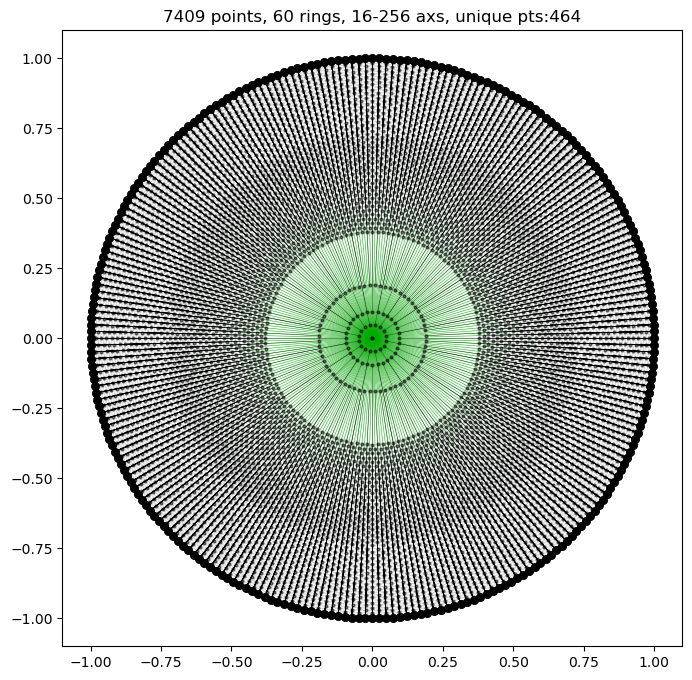

In [1274]:
# pts_in_shp = c_pts_on_crcl_rings(n_rings=20, n_on_outer_ring=8, min_n_on_ring=8, s=False, min_pnt_dist=0.05, max_pnt_dist=2)
pts_in_shp = c_pts_on_crcl_rings(n_rings=60, n_on_outer_ring=128, min_n_on_ring=16, s=True, min_pnt_dist=0.000001, max_pnt_dist=11.000001, max_dens=5)

In [ ]:
def c_pts_in_shp(
    n_pts:int=10,
    shape_scale:int = 1, 
    shape_name='circle',
    loc_descr_str:str='rings',#'grid', 'rings'
    min_dist:int=0,# minimum distance between pts
    poss_loc_grid_xy:np.ndarray=None, #zip(np.linspace(5,10,6),np.linspace(15,20,6))
    n_rings:int=20,#specify how many radiuses should  pts density 
    d_rings_scale=lambda r_i: r_i**.75,# r_i: r_i=even distance between rings => higher density close to center 
    n_pts_f_str:str='const_den_sym',# 'const_n', 'const_den', 'const_den_sym', 
    n_pts_ring_f=lambda r_i:24,#max(1,int(4*r_i))#r_i:1 = same amount of pointd on each ring, r_i:r_i = same point density on each ring 
    max_n_on_ring=2**6,
    min_n_on_ring=2,
    spread_ngls:bool=True, # make sense to create more even distribution 
    regular:bool=True, # specifies whether pts distrubted evenly or not if loc_descr_str in 'grid', 'rings' 
    distr_centrality:int=1,# same as d_rings_scale and n_pts_ring_f?
    plot:bool=True,#
)->list:

    fig, ax = plt.subplots(figsize=(10,10))
    ax.add_patch( plt.Circle((0., 0.), 1, facecolor='#00000005', edgecolor='#600') )

    # 0-1:4=.125, .5, 
    if loc_descr_str == 'all':
        min_dist
        poss_locs = np.array(np.meshgrid(*poss_loc_grid_xy)).T.reshape(-1,len(list(poss_loc_grid_xy)))
        d = np.random.random(300)**(0.5*distr_centrality)
        a = math.pi * 2 * np.random.random(300)
        pts = np.array([(di*math.cos(a[i]), di*math.sin(a[i])) for i, di in enumerate(d)])
    elif loc_descr_str == 'grid':
        pts = np.array(np.meshgrid(*poss_loc_grid_xy)).T.reshape(-1,len(list(poss_loc_grid_xy)))
    else: # loc_descr_str == 'rings':
        out_dct = c_pts_on_crcl_rings( n_pts=n_pts, shape_scale=shape_scale, min_dist=min_dist, n_rings=n_rings, 
        d_rings_scale=d_rings_scale, n_pts_f_str=n_pts_f_str, n_pts_ring_f=n_pts_ring_f, max_n_on_ring=max_n_on_ring, 
        min_n_on_ring=min_n_on_ring, spread_ngls=spread_ngls, regular=regular, distr_centrality=distr_centrality, plot=plot, )
    return out_dct
# pts_in_shp = c_pts_in_shp(d_rings_scale=lambda r_i: r_i**.75 if r_i > .3 else r_i)
# pts_in_shp = c_pts_in_shp(d_rings_scale=lambda r_i: r_i**1, n_pts_ring_f=lambda r_i:48 )
# plt.plot(*pts_in_shp)
pts_in_shp = c_pts_in_shp(d_rings_scale=lambda r_i,e=0.9: ((r_i+1)**e -1.0)/((1+1)**e -1.0), n_pts_ring_f=lambda r_i:4*2**(int(r_i > .05)+int(r_i > .1)+int(r_i > .2)), n_rings=40)



[4, 8, 16, 32, 64] 5
0 5
1 13
2 29
3 61
4 125


NameError: name 'n_pts_rings' is not defined

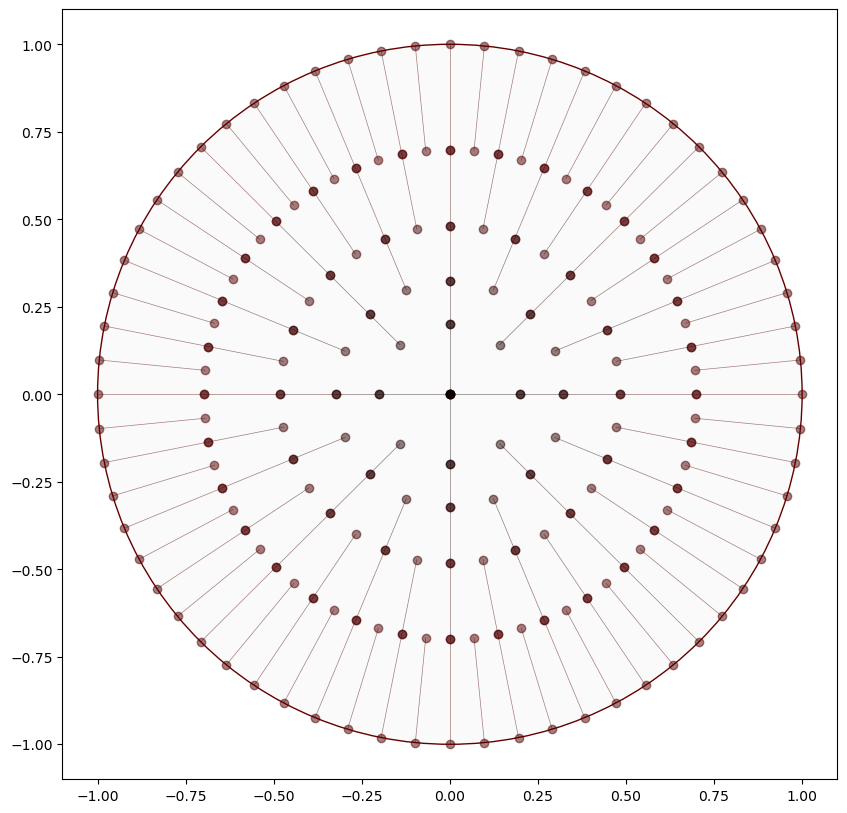

In [728]:
# scales with 
# pts_in_shp = c_pts_in_shp(d_rings_scale=lambda r_i,e=2.5: ((r_i+1)**e -1.0)/((1+1)**e -1.0), n_pts_ring_f=lambda r_i:4*2**(int(r_i > .05)+int(r_i > .1)+int(r_i > .2)))
pts_in_shp = c_pts_in_shp(d_rings_scale=lambda r_i,e=0.9: ((r_i+1)**e -1.0)/((1+1)**e -1.0), n_pts_ring_f=lambda r_i:4*2**(int(r_i > .05)+int(r_i > .1)+int(r_i > .2)), n_rings=40)
pts_in_shp = c_pts_in_shp(d_rings_scale=lambda r_i,e=0.5: ((r_i+1)**e -1.0)/((1+1)**e -1.0), n_pts_ring_f=lambda r_i:4*2**(int(r_i > .05)+int(r_i > .1)+int(r_i > .2)), n_rings=40)
pts_in_shp = c_pts_in_shp(d_rings_scale=lambda r_i,e=0.5: ((r_i+1)**e -1.0)/((1+1)**e -1.0), n_pts_ring_f=lambda r_i:4*2**(int(r_i > .05)+int(r_i > .1)+int(r_i > .2)))
pts_in_shp = c_pts_in_shp(d_rings_scale=lambda r_i,e=0.5: math.log((r_i*math.exp(1)+1))/math.log((math.exp(1)+1)), n_pts_ring_f=lambda r_i:4*2**(int(r_i > .05)+int(r_i > .1)+int(r_i > .2)))
# pts_in_shp = c_pts_in_shp(d_rings_scale=lambda r_i,e=1.5: ((r_i+1)**e -1.0)/((1+1)**e -1.0), n_pts_ring_f=lambda r_i:48)

In [611]:
print(sum([u+3*s for (n,u,s) in [
    (.12, .15, .73),
    (.5, .9, .86)
]]))
print(sum([u+3*s for (n,u,s) in[ 
    (.16, .19, .65),
    (.12, .16, .72)
]]))


5.82
4.460000000000001


In [2]:
# Calculate the euclidian distance in n-space of the route r traversing cities c, ending at the path start.
path_distance = lambda r,c: np.sum([np.linalg.norm(c[r[p]]-c[r[p-1]]) for p in range(len(r))])
step_distance = lambda r,c: [np.linalg.norm(c[r[p]]-c[r[p-1]]) for p in range(len(r))]
# Reverse the order of all elements from element i to element k in array r.
two_opt_swap = lambda r,i,k: np.concatenate((r[0:i],r[k:-len(r)+i-1:-1],r[k+1:len(r)]))

def two_opt(cities,improvement_threshold): # 2-opt Algorithm adapted from https://en.wikipedia.org/wiki/2-opt
    route = np.arange(cities.shape[0]) # Make an array of row numbers corresponding to cities.
    improvement_factor = 1 # Initialize the improvement factor.
    best_distance = path_distance(route,cities) # Calculate the distance of the initial path.
    while improvement_factor > improvement_threshold: # If the route is still improving, keep going!
        distance_to_beat = best_distance # Record the distance at the beginning of the loop.
        for swap_first in range(1,len(route)-2): # From each city except the first and last,
            for swap_last in range(swap_first+1,len(route)): # to each of the cities following,
                new_route = two_opt_swap(route,swap_first,swap_last) # try reversing the order of these cities
                new_distance = path_distance(new_route,cities) # and check the total distance with this modification.
                if new_distance < best_distance: # If the path distance is an improvement,
                    route = new_route # make this the accepted best route
                    best_distance = new_distance # and update the distance corresponding to this route.
        improvement_factor = 1 - best_distance/distance_to_beat # Calculate how much the route has improved.
    return route # When the route is no longer improving substantially, stop searching and return the route.



In [3]:

# Create a matrix of cities, with each row being a location in 2-space (function works in n-dimensions).
cities = np.random.RandomState(42).rand(70,2)

d = np.random.random(10)**.5
a = math.pi * 2 * np.random.random(10)
cities = np.array([(di*math.cos(a[i]), di*math.sin(a[i])) for i, di in enumerate(d)])
# Find a good route with 2-opt ("route" gives the order in which to travel to each city by row number.)
route = two_opt(cities,0.001)
path_distance(route,cities)


5.21710092823665

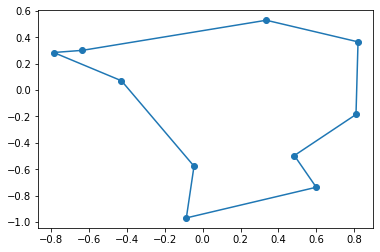

Route: [0 8 1 6 7 4 5 3 2 9]

Distance: 5.21710092823665


In [4]:
# Reorder the cities matrix by route order in a new matrix for plotting.
new_cities_order = np.concatenate((np.array([cities[route[i]] for i in range(len(route))]),np.array([cities[0]])))
# Plot the cities.
plt.scatter(cities[:,0],cities[:,1])
# Plot the path.
plt.plot(new_cities_order[:,0],new_cities_order[:,1])
plt.show()
# Print the route as row numbers and the total distance travelled by the path.
print("Route: " + str(route) + "\n\nDistance: " + str(path_distance(route,cities)))

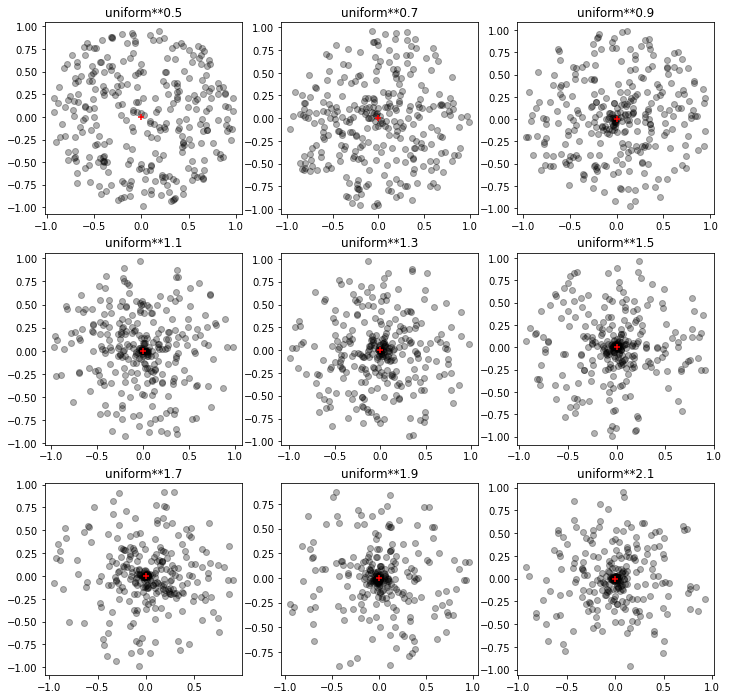

In [5]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12,12))
for i,ax in enumerate(axs.flat):
    centrality_param = 1+0.4*i

    d = np.random.random(300)**(0.5*centrality_param)
    a = math.pi * 2 * np.random.random(300)
    cities = np.array([(di*math.cos(a[i]), di*math.sin(a[i])) for i, di in enumerate(d)])
    ax.scatter(cities[:,0],cities[:,1], alpha=0.3, color='black')
    ax.scatter([0],[0], color="red", marker='+')
    ax.set_title('uniform**'+str(100*centrality_param*0.5//1/100))
plt.show()

In [6]:
N_min = 2
N_max = 60
centrality_param = 1

all_cities = [[] for n in range(N_min, N_max+1)]
all_path_lengths = [[] for n in range(N_min, N_max+1)]
all_step_lengths = [[] for n in range(N_min, N_max+1)]
all_neighbour_distances = [[] for n in range(N_min, N_max+1)]

step_distances = []
# all_neighbour_distances_after_removing_closest = [[n,[]] for n in range(N_min, N_max+1)]

N = N_min
while N <= N_max:
    for ni in range(flex_iterations(N)):
        d = np.random.random(N)**(0.5*centrality_param)
        a = math.pi * 2 * np.random.random(N)
        cities = np.array([(di*math.cos(a[i]), di*math.sin(a[i])) for i, di in enumerate(d)])
        route = two_opt(cities,0.001)
        all_cities[N-2]+=[[cities]]
        all_path_lengths[N-2] += [path_distance(route,cities)*(N-1)/N]
        all_step_lengths[N-2] += [[sorted(step_distance(route,cities))]]
        # all_neighbour_distances[N-2] += [[nearest_neighbour_distances]]
    N += 1



NameError: name 'flex_iterations' is not defined

[[ 1.14911798]
 [ 0.31897985]
 [-0.00266168]]


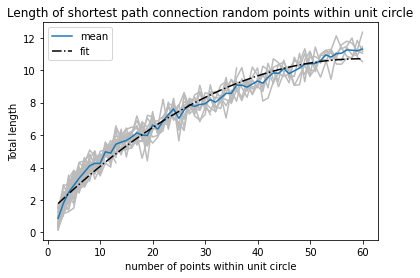

In [ ]:
per_link = False
def per_link_mult(i, per_link=per_link):
    if not per_link:
        return 1
    return 1/(i+1)

path_lengths_mean = [sum(ls)/len(ls) for ls in all_path_lengths]
path_lengths_var = [sum((ls-m)**2)/(len(ls)-1) for (ls, m) in zip(all_path_lengths, path_lengths_mean)]
path_lengths_upper = [m+2*v for (m, v) in zip(path_lengths_mean, path_lengths_var)]
path_lengths_lower = [m-2*v for (m, v) in zip(path_lengths_mean, path_lengths_var)]
x = list(range(2,len(all_cities)+2))
y1 = [x*per_link_mult(i) for i,x in enumerate(path_lengths_mean)]
y2 = [x*per_link_mult(i) for i,x in enumerate(path_lengths_upper)]
y3 = [x*per_link_mult(i) for i,x in enumerate(path_lengths_lower)]

for j in range(len(all_cities[0])):
    plt.plot(x, [None if j >= len(x) else x[j]*per_link_mult(i) for i,x in enumerate(all_path_lengths)], color ='#bbbbbb')


plt.plot(x, y1, label ='mean')
# plt.plot(x, y2, '-.', label ='path_lengths_upper')
# plt.plot(x, y3, '-.', label ='path_lengths_lower')


X=np.matrix([[item for sublist in [[xs**p for i in range(len(all_path_lengths[xs-2]))] for xs in x] for item in sublist] for p in range(3)]).T
y=np.matrix([[yx] for yx in [item for sublist in [all_path_lengths[xs-2] for xs in x] for item in sublist]])

XT=X.T
XTX=XT@X
inv=np.linalg.pinv(XTX)
theta=(inv@XT)@y
print(theta)

yfitted = [sum([float(x)*(e**i) for i, x in enumerate(theta)]) for e in x]
plt.plot(x, yfitted, '-.', label ='fit', color='black')

plt.xlabel("number of points within unit circle")
plt.ylabel("Total length")
plt.legend()
plt.title('Length of shortest path connection random points within unit circle')
plt.show()
#plot (-25+28x**.2-.1x+.3x*.98**x)*.5/(x(60-.5x)) and (-25+28x**.2-.1x+.3x*.98**x)*.5/(x(60-.7x)) and (-25+28x**.2-.1x+.3x*.98**x)*.5/(x(60-.8x*.9975**x)) and (-25+28x**.2-.1x+.3x*.98**x)*.5/(x(60-.7(x/2)*.9975**x)) from 2 to 100


## Manually try to obtain best fit for function

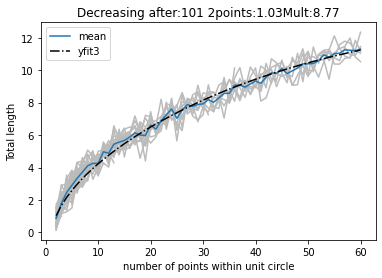

In [ ]:
for j in range(len(all_cities[0])):
    plt.plot(x, [None if j >= len(x) else x[j]*per_link_mult(i) for i,x in enumerate(all_path_lengths)], color ='#bbbbbb')
plt.plot(x, y1, label ='mean')



def fitFun(e): return 1.2*(e-1)/(e**.5) + 0.1*e - 0.0037*e**1.7
plt.plot(x, [fitFun(e) for e in x], '-.', label ='yfit3', color='black')

plt.xlabel("number of points within unit circle")
plt.ylabel("Total length")
plt.legend()
seq = [fitFun(e) for e in range(2,160)]

plt.title('Decreasing after:'+str(min([i for (i,r) in enumerate(seq) if i>2 and seq[i-1]>r]))+' 2points:'+str(fitFun(2)*100//1/100)+"Mult:"+str(9.1/fitFun(2)*100//1/100))
plt.show()

[[ 2.10369721]
 [ 0.28057039]
 [-0.00218711]]


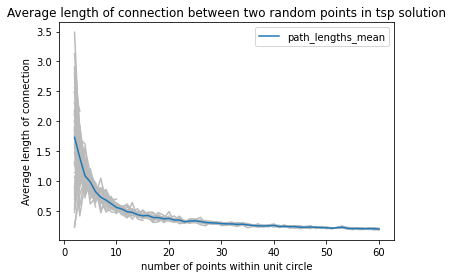

In [ ]:
per_link = True
def per_link_mult(i, per_link=per_link):
    if not per_link:
        return 1
    return 1/(i+1)

path_lengths_mean = [sum(ls)/len(ls) for ls in all_path_lengths]
path_lengths_var = [sum((ls-m)**2)/(len(ls)-1) for (ls, m) in zip(all_path_lengths, path_lengths_mean)]
path_lengths_upper = [m+2*v for (m, v) in zip(path_lengths_mean, path_lengths_var)]
path_lengths_lower = [m-2*v for (m, v) in zip(path_lengths_mean, path_lengths_var)]
x = list(range(2,len(all_cities)+2))
y1 = [x*per_link_mult(i) for i,x in enumerate(path_lengths_mean)]
y2 = [x*per_link_mult(i) for i,x in enumerate(path_lengths_upper)]
y3 = [x*per_link_mult(i) for i,x in enumerate(path_lengths_lower)]

for j in range(len(all_cities[0])):
    plt.plot(x, [None if j >= len(x) else x[j]*per_link_mult(i) for i,x in enumerate(all_path_lengths)], color ='#bbbbbb')


plt.plot(x, y1, label ='path_lengths_mean')
# plt.plot(x, y2, '-.', label ='path_lengths_upper')
# plt.plot(x, y3, '-.', label ='path_lengths_lower')


X=np.matrix([[item for sublist in [[xs**p for i in range(len(all_path_lengths[xs-2]))] for xs in x] for item in sublist] for p in range(3)]).T
y=np.matrix([[yx] for yx in [item for sublist in [all_path_lengths[xs-2] for xs in x] for item in sublist]])

XT=X.T
XTX=XT@X
inv=np.linalg.pinv(XTX)
theta=(inv@XT)@y
print(theta)

yfitted = [sum([float(x)*(e**i) for i, x in enumerate(theta)]) for e in x]
# plt.plot(x, yfitted, '-.', label ='fit', color='black')

plt.xlabel("number of points within unit circle")
plt.ylabel("Average length of connection")
plt.legend()
plt.title('Average length of connection between two random points in tsp solution')
plt.show()



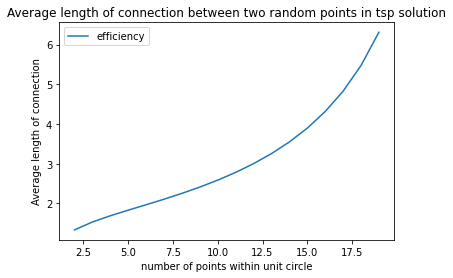

In [ ]:
basecase=7
rg = list(range(2,20))
vals = [mult*(sum([float(x)*(basecase**i) for i, x in enumerate(theta)])+basecase*0.1)/(sum([float(x)*((mult*basecase)**i) for i, x in enumerate(theta)])+mult*basecase*0.1) for mult in rg]

plt.plot(rg, vals, label ='efficiency')

plt.xlabel("number of points within unit circle")
plt.ylabel("Average length of connection")
plt.legend()
plt.title('Average length of connection between two random points in tsp solution')
plt.show()


In [ ]:
# first solve TSP
# Then look for subdivision of problem in areas where all agents contribute significantly
# when to accept the solution found?
# how to weight?
total_length = 10
n_busses = 2
min_bus_line = total_length * 1.5/((n_busses)**1.1)
min_bus_line
max_bus_line = total_length *(n_busses**1.1+1)/(2*n_busses**1.1)
max_bus_line
# choose points close to center to begin with
# each point has a set of candidates that is a share of approx min(1-2*total_length/(3/2*n_busses**1.1), ) of other points 

7.332582478842019

# Now let number of be vehicles >1 and roughly scaling with demand

### Assume: 
A vehicle does a tour for 1 hour. How many passengers can it serve? Travel times are normally distributed from 15-45 mins. So it would be maxed out at twice its capacity!
Its capacity may (in this smaller problem) be 7 passengers. So 14 passengers per vehicle.
Create pickup and dropoff locations that are correlated (on rather inside city center the other rather outside)
Possibly think of creating an area filter where those passengers remain that have pickup and dropoff within that area
Maybe start with worst passengers: Long distance, far from center, and low correlation on direction. 

#### Surface area and average distance
Sqrt(890)=30, sqrt(160)=13, 5x vs 2.5
Simple ex: small town only one market in center. Large town multiple in center and subcenter.